In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('processed_train.csv')
data.head()

,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,...,Platform_windows8,Processor_x64,Processor_x86,Census_DeviceFamily_Windows.Server,Census_OSArchitecture_arm64,Census_OSArchitecture_x86,Census_GenuineStateName_IS_GENUINE,Census_GenuineStateName_OFFLINE,Census_GenuineStateName_UNKNOWN,HasDetections
0,0.552153,0.530941,0.587952,7.0,0,53447.0,1.0,1.0,1,29,...,0,1,0,0,0,0,1,0,0,0
1,0.448751,0.528931,0.484434,7.0,0,53447.0,1.0,1.0,1,93,...,0,1,0,0,0,0,0,1,0,0
2,0.552153,0.530941,0.557522,7.0,0,53447.0,1.0,1.0,1,86,...,0,1,0,0,0,0,1,0,0,0
3,0.552153,0.530941,0.482759,7.0,0,53447.0,1.0,1.0,1,97,...,0,1,0,0,0,0,1,0,0,0
4,0.493175,0.530941,0.505721,7.0,0,53447.0,1.0,1.0,1,164,...,0,1,0,0,0,0,1,0,0,0


Разобьем выборку на тест и трейн

In [3]:
from sklearn.model_selection import train_test_split

x = data.drop('HasDetections', axis=1)
y = data['HasDetections']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=33)

Обучите LogReg и SVM с помощью классов `LogisticRegression` и `LinearSVC`. Добавьте шаг стандартизации данных в пайплайны. Для разнообразия, возьмем `MinMaxScaler`. Пайплайны запишем в переменные `pipe_lr` и `pipe_svm` соответственно!

In [4]:
### Your code is here
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler

pipe_lr = Pipeline([('Scaler', MinMaxScaler()), ('LR', LogisticRegression())])
pipe_svm = Pipeline([('Scaler', MinMaxScaler()), ('SVM', LinearSVC())])

pipe_lr.fit(x_train, y_train)
pipe_svm.fit(x_train, y_train)

Pipeline(steps=[('Scaler', MinMaxScaler()), ('SVM', LinearSVC())])

In [5]:
print(f'Logistic Regression accuracy: {round(pipe_lr.score(x_test, y_test), 3)}')
print(f'SVM accuracy: {round(pipe_svm.score(x_test, y_test), 3)}')

Logistic Regression accuracy: 0.843
SVM accuracy: 0.84


Постройте ROC для обеих моделей, посчитайте AUC . Конечно же, обучение проводите на трейне, а замеры - на тесте.

Заметьте! Классическая реализация `SVM`, как и в лекциях, не дает никакой оценки вероятности. Чтобы трансформировать выходы в вероятности, на практике мы использовали функцию-сигмоиду. Здесь предлагаем Вам трансформировать выходы `decision_function` в вероятности пропорциональным способом.

Например, вы обучили `SVM`, и на тестовых данных модель выдала следующие выходы `decision_function`:

(-10, -5, 0, +2, +10, +15)

Для каждого числа необходимо сделать преобразование в выражение вида `P(y = +1 | x)`.

С одной стороны, отрицательный знак числа будет сигнализировать нам о том, что `P(y = +1 | x) < 0.5`.

Тогда положительный о том, что `P(y = +1 | x) > 0.5`. 

С другой стороны, для тех объектов, в которых модель уверена больше всего, положим краевые вероятности. Для примера выше:

`P(y = +1 | -10) = 0`, `P(y = +1 | +15) = 1`. Для всех промежуточных объектов применим пропорциональное преобразование. Например:

$$
P(y = +1 | -5) = \frac{|-5-(-10)|}{|-10|} \cdot 0.5
$$

$$
P(y = +1 | +2) = \frac{|+2|}{|+15|} \cdot 0.5 + 0.5
$$
Таким образом мы можем перевести выходы SVM в отрезок [0;1] и попробовать интерпретировать новые числа как вероятности, чтобы изобразить калибровочную кривую. При таком преобразовании пропорции внутри первоначально отрицательных и внутри положительных чисел сохраняются.

In [6]:
from sklearn.metrics import roc_curve, RocCurveDisplay, auc

ROC-AUC for Logistic Regression: 0.689


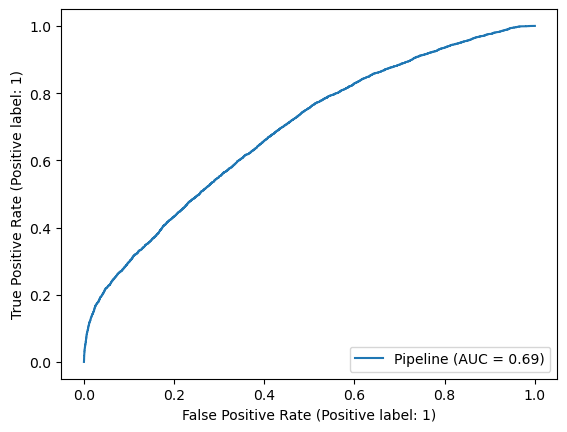

In [7]:
### С изображением рок-кривой для ЛогРега не будет проблем:
### Your code is here
fpr, tpr, thresholds = roc_curve(y_test, pipe_lr.predict_proba(x_test)[:, 1])
RocCurveDisplay.from_estimator(pipe_lr, x_test, y_test)
roc_auc_lr = auc(fpr, tpr)
print(f'ROC-AUC for Logistic Regression: {round(roc_auc_lr, 3)}')

In [8]:
### А для того, чтобы построить и изобразить рок-кривую для SVM, придется
### в начале преобразовать выходы pipe_svm.decision_function
### Your code is here
decision_preds = pipe_svm.decision_function(x_test)

min_pred = min(decision_preds)
max_pred = max(decision_preds)

preds_svm = [abs((x-min_pred)/min_pred * 0.5)
            if x <= 0
            else abs(x/max_pred*0.5 + 0.5)
            for x in decision_preds]

ROC-AUC for SVM: 0.688


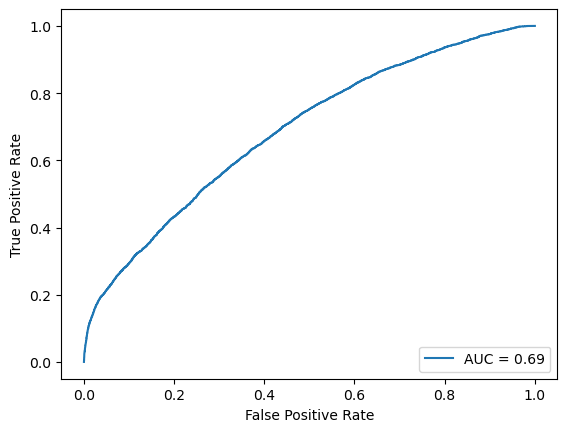

In [9]:
fpr, tpr, thresholds = roc_curve(y_test, preds_svm)
roc_auc_svm = auc(fpr, tpr)
print(f'ROC-AUC for SVM: {round(roc_auc_svm, 3)}')
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_svm).plot()
plt.show()

Постройте калибровочные кривые для обеих моделей. Методом from_estimator для svm воспользоваться не получится.

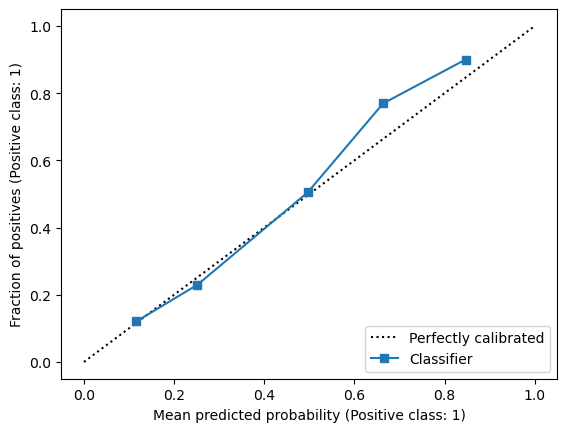

In [10]:
### Your code is here
from sklearn.calibration import calibration_curve, CalibrationDisplay
CalibrationDisplay.from_predictions(y_test, pipe_lr.predict_proba(x_test)[:, 1])

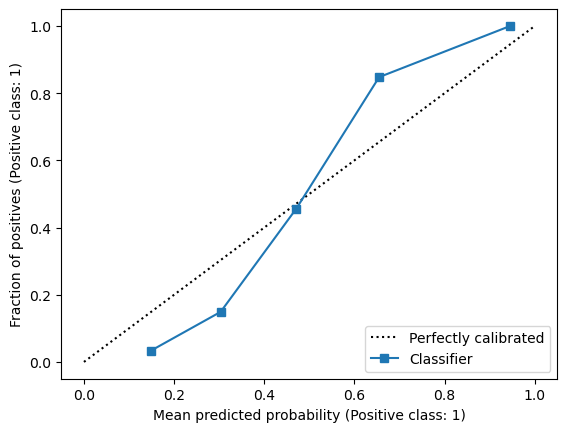

In [11]:
### Your code is here
CalibrationDisplay.from_predictions(y_test, preds_svm)

**Какая калибровочная кривая ближе к диагонали?  Откалибруйте SVM способом как в практике и изобразите новую кривую!

In [12]:
### Калибровка
### Your code is here
from sklearn.calibration import CalibratedClassifierCV
calibration = CalibratedClassifierCV(pipe_svm, cv=5, method='sigmoid')
calibration.fit(x_train, y_train)

calibrated_probs = calibration.predict_proba(x_test)[:, 1]

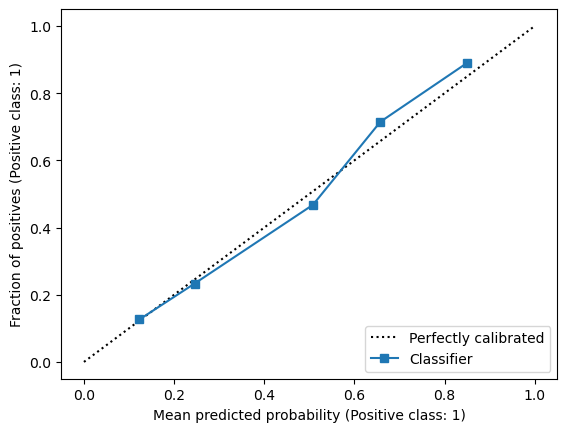

In [13]:
### Новая кривая
### Your code is here
CalibrationDisplay.from_predictions(y_test, calibrated_probs)

In [14]:
### Калибровка методом Isotonic
calibration_iso = CalibratedClassifierCV(pipe_svm, cv=5, method='isotonic')
calibration_iso.fit(x_train, y_train)

calibrated_probs_iso = calibration.predict_proba(x_test)[:, 1]

Text(0.5, 1.0, 'Calibration plots')

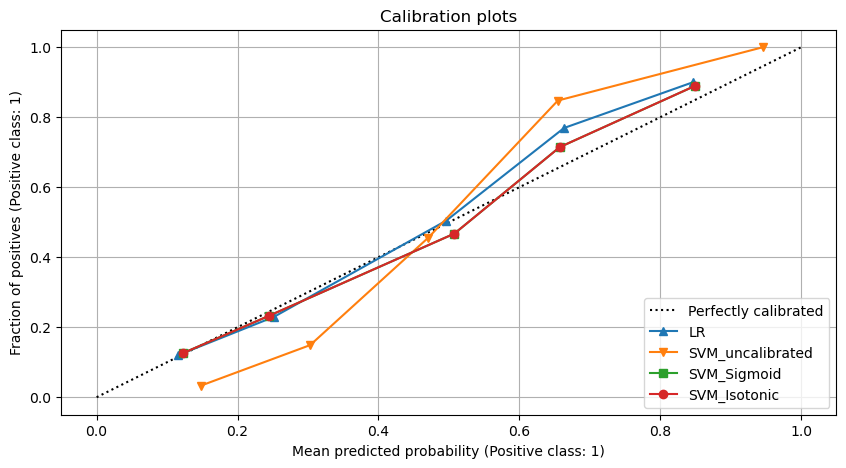

In [15]:
### Отображение всех кривых на одном графике
fig, ax = plt.subplots(figsize=(10, 5))

preds = [pipe_lr.predict_proba(x_test)[:, 1], preds_svm, calibrated_probs, calibrated_probs_iso]
names = ['LR', 'SVM_uncalibrated', 'SVM_Sigmoid', 'SVM_Isotonic']
markers = ["^", "v", "s", "o"]

for i in range(len(preds)):
    CalibrationDisplay.from_predictions(y_test, preds[i], ax=ax, name=names[i], marker=markers[i])

ax.grid()
ax.set_title("Calibration plots")